# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 7: Findings

# Introduction

In this notebook, we will gather all the results obtained from the previous notebooks and analyze the key features extracted as indicators for the selected models to make predictions. We will discuss the possible reasons for these scenarios and ultimately address the predefined problem statement: **What are the key factors that determine an outstanding Airbnb listing?**

***

## Import Libraries <a id='a1'></a>

In [2]:
# Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

# Scipy Library for sparse  matrix
from scipy.sparse import csr_matrix

# NLP Libraries
import nltk
import re
import string
import html
import contractions
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier

# Download from nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dummy Classifer 
from sklearn.dummy import DummyClassifier

# Modelling Libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import joblib
import pickle as pk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Import customized functions

In [3]:
%run -i my_function.py

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading Two Review Datasets

In [4]:
# Load uncollapsed review data
df_reviews_by_listing= joblib.load('data/df_reviews_by_listing.pkl')

# Load collapsed review data
df_collapsed_reviews_by_listing= joblib.load('data/df_collapsed_reviews_by_listing.pkl')

#### Ignore userwarnings

In [5]:
import warnings

# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

***

## Helper function: Plotting Top Indicating Word Features

In [6]:
# Define plotting function for extracting key features for Decision Tree or Random Forest Classifiers
def extract_key_words_plot(grid, ct, n_words, ct_prefix):
    '''
    Returns a barplot that shows the top words with
    highest coefficients in the selected best model
    in the fitted GridSearch
    
    PARAMETERS:
    - grid: Fitted resulted Grid
    - ct: Column Transformer
    - n_words: int, Number of words that will be shown in the plot
    - ct_prefix: str, The prefix of the word features
    
    RETURNS:
    - two barplots that show the top indicating words and listing features for the best model selected
    
    '''  
    # Extract the best model from grid search result
    best_model= grid.best_estimator_
    
    # Extract feature coefficients out of best model in the resulted grid
    coefficients = best_model.named_steps['model'].feature_importances_
    
    # Extract feature names from column transformer
    feature_names = ct.get_feature_names_out()
    
    # Generate column indicate if the feature is numerical or word related
    if_word=[]
    for i in range(len(feature_names)):
        if feature_names[i][0] == 'n':
            if_word.append(0)
        else:
            if_word.append(1)
    
    # create dataframe contains feature names with corresponding coefficients resulted from best model
    df_features = pd.DataFrame({'coefficients':coefficients, 'feature_names': feature_names, 'if_word': if_word})     
    
    # Split into numerical feature dataframe and word feature daraframe
    df_word = df_features[df_features['if_word']==1]
    df_num =  df_features[df_features['if_word']==0]
    
    # Order the features based on coefficients and remove prefix
    df_word = df_word.sort_values('coefficients', ascending=False).reset_index(drop=True).loc[:n_words-1]
    df_num = df_num.sort_values('coefficients', ascending=False).reset_index(drop=True).loc[:n_words-5]
    
    # Plot separate plots for word features and numerical features on two subplots
    
    plt.subplots(1, 2, figsize=(30,10))  # one row, two columns 
    
    # Word Features plot
    plt.subplot(1,2, 1)  # slot 1
    plt.barh(width=df_word['coefficients'], y=df_word['feature_names'].str.replace(ct_prefix+'__', ''), color='#FF5A5F')
    plt.title(f'Top {n_words} Indicating phrases', fontsize=30)
    plt.ylabel('Word Features', fontsize=18)
    plt.xlabel('Model Coefficients', fontsize=15)
    plt.xticks(rotation=45)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=25)
    
    # Numerical Features plot
    plt.subplot(1,2, 2)  # slot 2
    plt.barh(width=df_num['coefficients'], y=df_num['feature_names'].str.replace('numeric__', ''), color='#FF5A5F')
    plt.title(f'Top {n_words-4} Indicating Listing Features', fontsize=30)
    plt.ylabel('Listing Features', fontsize=18)
    plt.xlabel('Model Coefficients', fontsize=15)
    plt.xticks(rotation=45)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=25)
    ax=plt.gca()
    ax.yaxis.set_label_position("right")
    
    plt.tight_layout()
    plt.savefig('grid2_features.jpg', dpi =300)
    plt.show()

***

# Analysis on Dataset 1
**'Corresponding listing details aggregate to individual review datapoints'**

In this section, we will import all the results from the notebook **4_Modelling_Review_Uncollapsed**, evaluate them, and discuss our findings.

## GridSearch 1 Results and Summary

During the first grid search, we conducted a general sweep where logistic regression and decision tree classifier with wide ranges of parameters were utilized. The detailed model results can be seen below:

We will evaluate the best-performing models in the following stages:

First, we will use classification evaluation metrics, including classification report and confusion matrix, to evaluate our selected model's performance. Next, we will employ a customized plotting function to extract keywords and features related to listings that the model used to make its predictions. Finally, we will discuss potential reasons for these extracted words and explain our next steps in the modeling process.

In [7]:
# Define current dataset training and testing data
X = df_reviews_by_listing.drop(['listing_id',
                               'Overall_sentiment',
                               'accuracy_sentiment',
                               'cleanliness_sentiment',
                               'checkin_sentiment',
                               'communication_sentiment',
                               'location_sentiment',
                               'value_sentiment'], axis=1)
y = df_reviews_by_listing['Overall_sentiment']

# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Return downsampled training data
X_train_sample, y_train_sample = downsample_train(X_train, y_train, 'Overall_sentiment', 0.03)

# Extract numerical column names for column transformer
numeric_columns = X.select_dtypes(exclude='object').columns.to_list()

# Define column transformers
ct_tfidf = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))

# Obtain tfidf transformed training and testing data
X_train_ct_tfidf= ct_tfidf.fit_transform(X_train_sample)
X_test_ct_tfidf = ct_tfidf.transform(X_test)

In [7]:
# Import gridsearch result dataframe
fittedgrid_1_tfidf = joblib.load('data/fittedgrid_1_tfidf.pkl')

# Expand column width to see full results
pd.set_option('display.max_colwidth', None)

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid1_results_df = pd.DataFrame(fittedgrid_1_tfidf.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid1_results = fittedgrid1_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_1 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid1_results.head(10) 

GridSearch_1 Cross_Validation Results


,rank_test_score,params,mean_test_score
92,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.912732
74,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.912732
82,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.912732
83,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.912732
91,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.912732
73,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.912732
84,7,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.910225
75,7,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.910225
93,7,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.910225
85,10,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_state': 123}",0.904958


#### GridSearch_1 Best Model Confusion Matrix

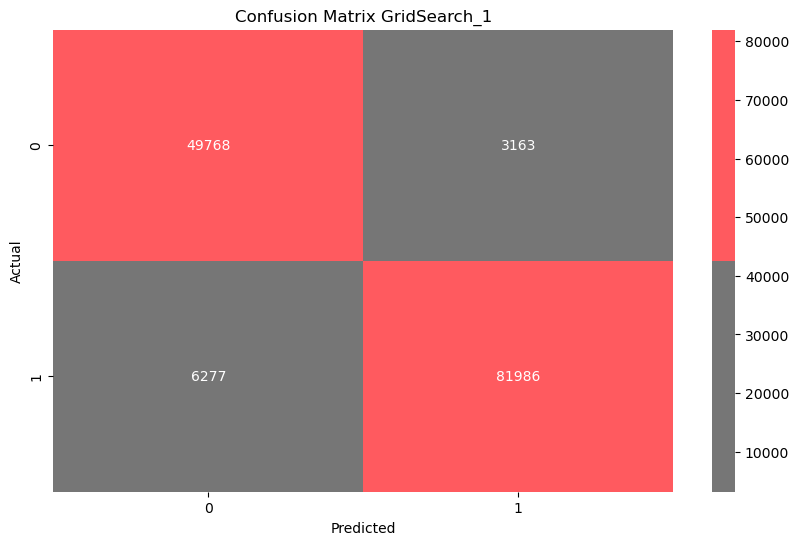

In [12]:
# Test data predictions 
y_pred_grid1 = fittedgrid_1_tfidf.best_estimator_.predict(X_test_ct_tfidf)

# Compute Confusion Matrix
Confusion_Matrix_grid1 = confusion_matrix(y_test, y_pred_grid1)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid1, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_1')

plt.show()

#### GridSearch_1 Classification Report

In [13]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid1))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     52931
           1       0.96      0.93      0.95     88263

    accuracy                           0.93    141194
   macro avg       0.93      0.93      0.93    141194
weighted avg       0.93      0.93      0.93    141194



#### GridSearch_1 Word Features

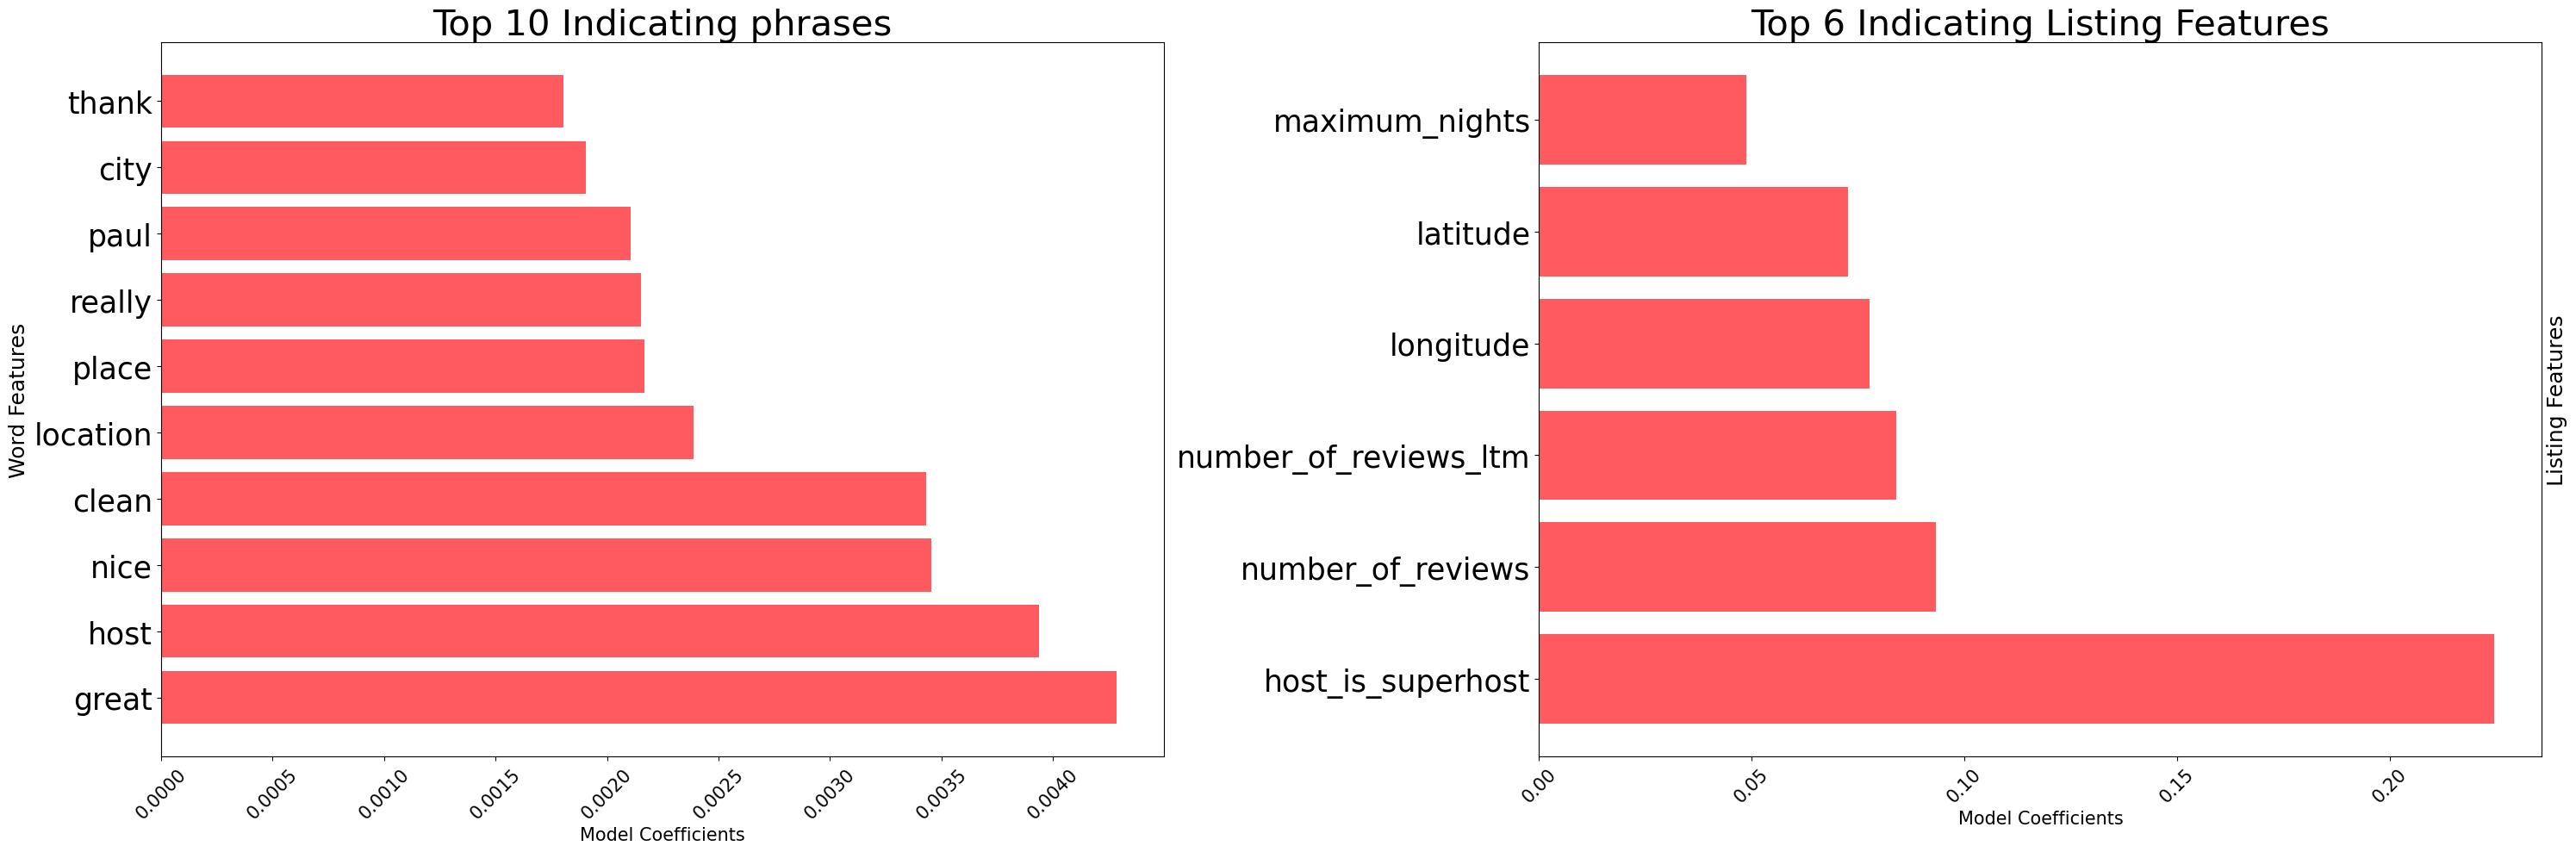

In [54]:
extract_key_words_plot(fittedgrid_1_tfidf, ct_tfidf, 10, 'ct_tfidf')

### GridSearch 1 Summary:

From the first plot extracted from the best model selected after the first GridSearch, we observe that the word features are mostly adjectives, such as **'great'** and **'nice'**. Alongside these adjectives, we also see some nouns related to subratings, such as **'location'**, **'clean'**, and **'host'**. This suggests that subratings will be very important feature aspects in determining if a listing is outstanding. Additionally, we see on the right that whether a **host is a superhost or not** is an extremely important factor, as it carries the highest model coefficient. This aligns with what we found during the EDA stage.

From these plots, we would like to further improve our model's **interpretability**, as the words extracted failed to provide any actionable insights. Therefore, we will include **n-grams** in our GridSearch and hope for more insightful **phrases** for us to analyze.

***

## GridSearch 2 Results and Summary

In the second grid search, we attempted to achieve better model interpretability by adding n-grams in the text vectorization stage. Additionally, we excluded underperforming logistic regression models and included random forests, aiming for better model performance as well. The detailed model results can be seen below.

In [9]:
# Define column transformers
ct_tfidf_ngrams = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))

# Obtain tfidf transformed training and testing data
X_train_ct_tfidf_ngrams= ct_tfidf_ngrams.fit_transform(X_train_sample)
X_test_ct_tfidf_ngrams = ct_tfidf_ngrams.transform(X_test)

In [16]:
# Import gridsearch result dataframe
fittedgrid_2_tfidf = joblib.load('data/fittedgrid_2_tfidf.pkl')

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid2_results_df = pd.DataFrame(fittedgrid_2_tfidf.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid2_results = fittedgrid2_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_2 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid2_results.head(10) 

GridSearch_2 Cross_Validation Results


,rank_test_score,params,mean_test_score
0,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.927352
1,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__random_state': 123}",0.927352
2,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.927352
3,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.927352
4,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__random_state': 123}",0.927352
5,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.927352
6,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.927352
7,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__random_state': 123}",0.927352
8,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.927352
17,10,"{'model': RandomForestClassifier(), 'model__criterion': 'gini', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__n_estimators': 15, 'model__random_state': 123}",0.825332


#### GridSearch_2 Best Model Confusion Matrix

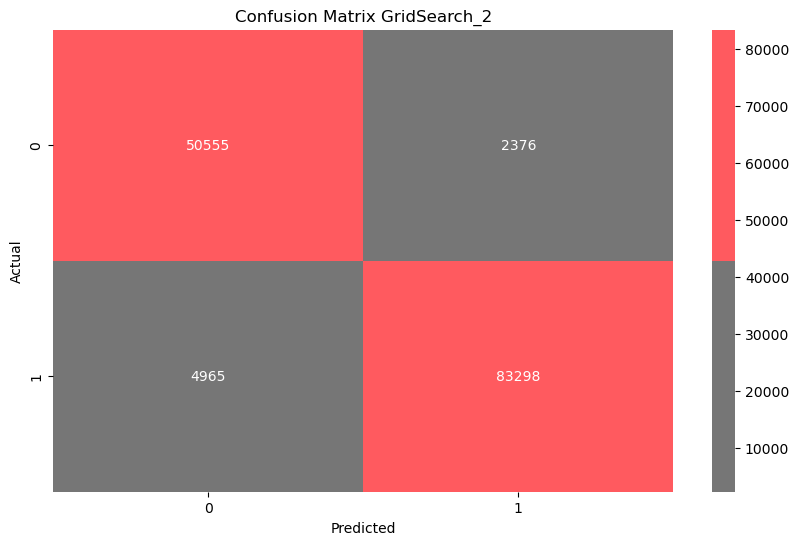

In [17]:
# Test data predictions 
y_pred_grid2 = fittedgrid_2_tfidf.best_estimator_.predict(X_test_ct_tfidf_ngrams)

# Compute Confusion Matrix
Confusion_Matrix_grid2 = confusion_matrix(y_test, y_pred_grid2)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid2, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_2')

plt.show()

#### GridSearch_2 Classification Report

In [18]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid2))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     52931
           1       0.97      0.94      0.96     88263

    accuracy                           0.95    141194
   macro avg       0.94      0.95      0.95    141194
weighted avg       0.95      0.95      0.95    141194



#### GridSearch_2 Phrases Features

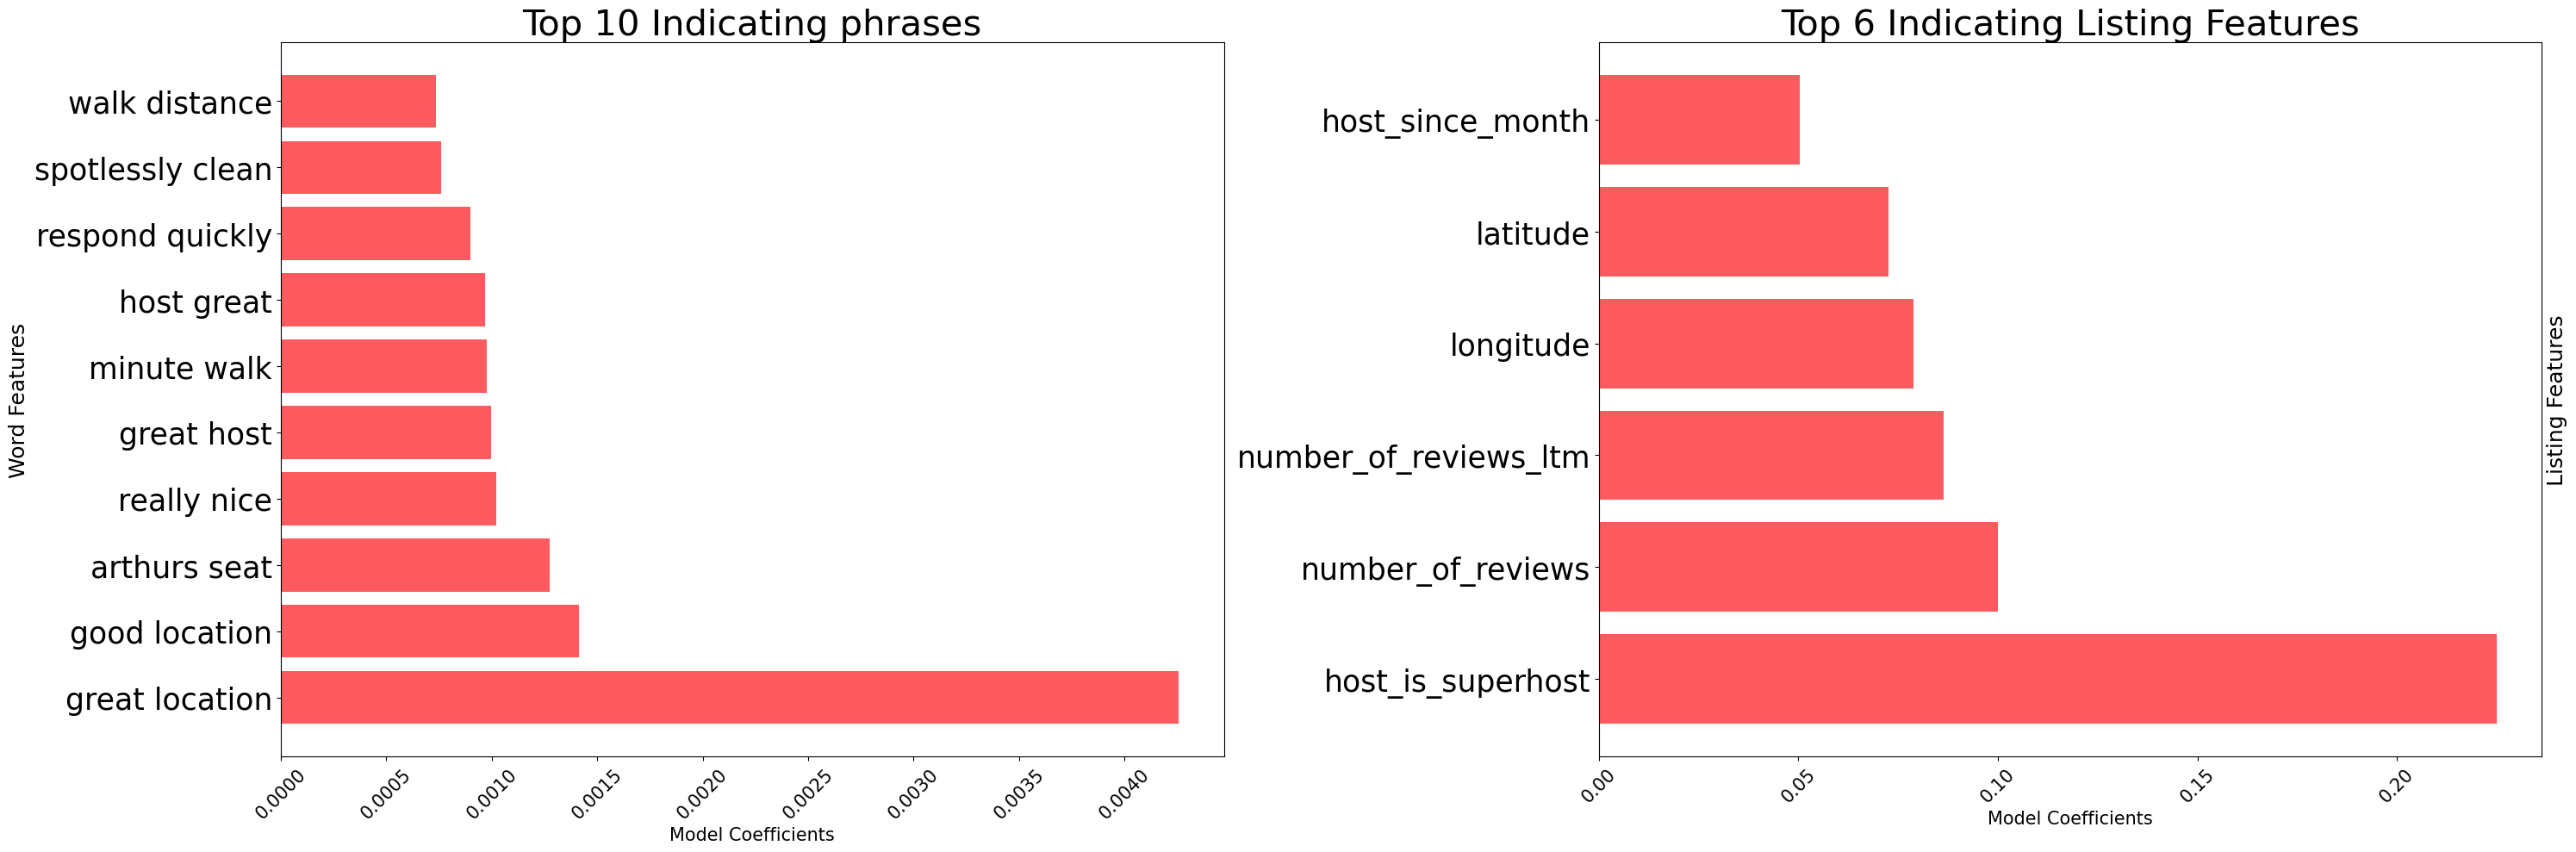

In [55]:
extract_key_words_plot(fittedgrid_2_tfidf, ct_tfidf_ngrams, 10, 'ct_tfidf')

### GridSearch_2 Summary

After including n-grams in our analysis, we can see that the key indicating word features have improved in terms of interpretability. Key phrases we observe include several location-related phrases, such as **'Arthurs Seat'**, **'minutes walk'**, and **'walking distance'**, etc. Additionally, we can also observe some well-defined subrating-related phrases such as **'spotlessly clean'** and **'respond quickly'**. These phrases further suggest that one can find actionable insights simply by looking at the subrating categories, as these words and phrases are also key indicators in guest reviews to predict if a listing is outstanding or not in terms of overall rating score.

Next, we wish to see better model interpretability after we change our dataset to perform analysis. The changed dataset contains overall reviews corresponds to overall Airbnb listings.

***

# Analysis on Dataset 2
**'Condensed review data with same corresponding listing details'**

In this section, we will import all the results from the notebook **5_Modelling_Collapsed_Reviews**, evaluate them, and discuss our findings.

In [8]:
# Define X and y for the future model
X = df_collapsed_reviews_by_listing.drop(['Overall_sentiment',
                                          'accuracy_sentiment',
                                          'cleanliness_sentiment',
                                          'checkin_sentiment',
                                          'communication_sentiment',
                                          'location_sentiment',
                                          'value_sentiment'], axis=1)
y = df_collapsed_reviews_by_listing['Overall_sentiment']

# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Obtain tfidf transformed training and testing data
X_train_ct_tfidf= ct_tfidf.fit_transform(X_train)
X_test_ct_tfidf = ct_tfidf.transform(X_test)

## GridSearch 3 Results and Summary

In [11]:
# Import pre-trained grid
fittedgrid_1_bow_collapsed = joblib.load('data/fittedgrid_1_bow_collapsed.pkl')

# Expand column width to see full results
pd.set_option('display.max_colwidth', None)

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid1_results_df = pd.DataFrame(fittedgrid_1_bow_collapsed.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid1_results = fittedgrid1_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_3 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid1_results.head(10) 

GridSearch_3 Cross_Validation Results


,rank_test_score,params,mean_test_score
0,1,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.001, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.835599
1,2,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.01, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.823335
2,3,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 0.1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.817110
3,4,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.812753
4,5,"{'model': LogisticRegression(C=0.001, max_iter=10000, random_state=123), 'model__C': 10, 'model__max_iter': 10000, 'model__penalty': 'l2', 'model__random_state': 123}",0.811666
9,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__random_state': 123}",0.789064
5,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.789064
6,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.789064
7,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.789064
8,6,"{'model': DecisionTreeClassifier(), 'model__criterion': 'gini', 'model__max_depth': 2, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_state': 123}",0.789064


#### GridSearch_3 Best Model Confusion Matrix

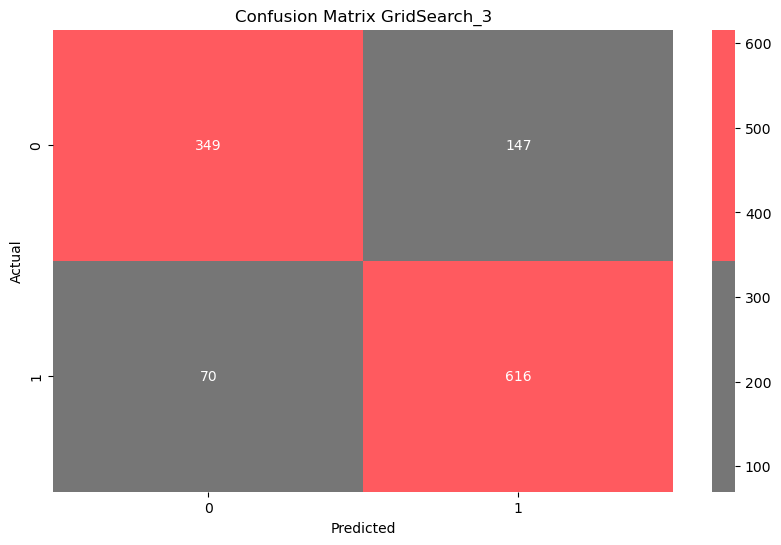

In [30]:
# Test data predictions 
y_pred_grid3 = fittedgrid_1_bow_collapsed.best_estimator_.predict(X_test_ct_tfidf)

# Compute Confusion Matrix
Confusion_Matrix_grid3 = confusion_matrix(y_test, y_pred_grid3)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid3, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_3')

plt.show()

#### GridSearch_3 Classification Report

In [29]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid3))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       496
           1       0.81      0.90      0.85       686

    accuracy                           0.82      1182
   macro avg       0.82      0.80      0.81      1182
weighted avg       0.82      0.82      0.81      1182



#### GridSearch_3 Word Features

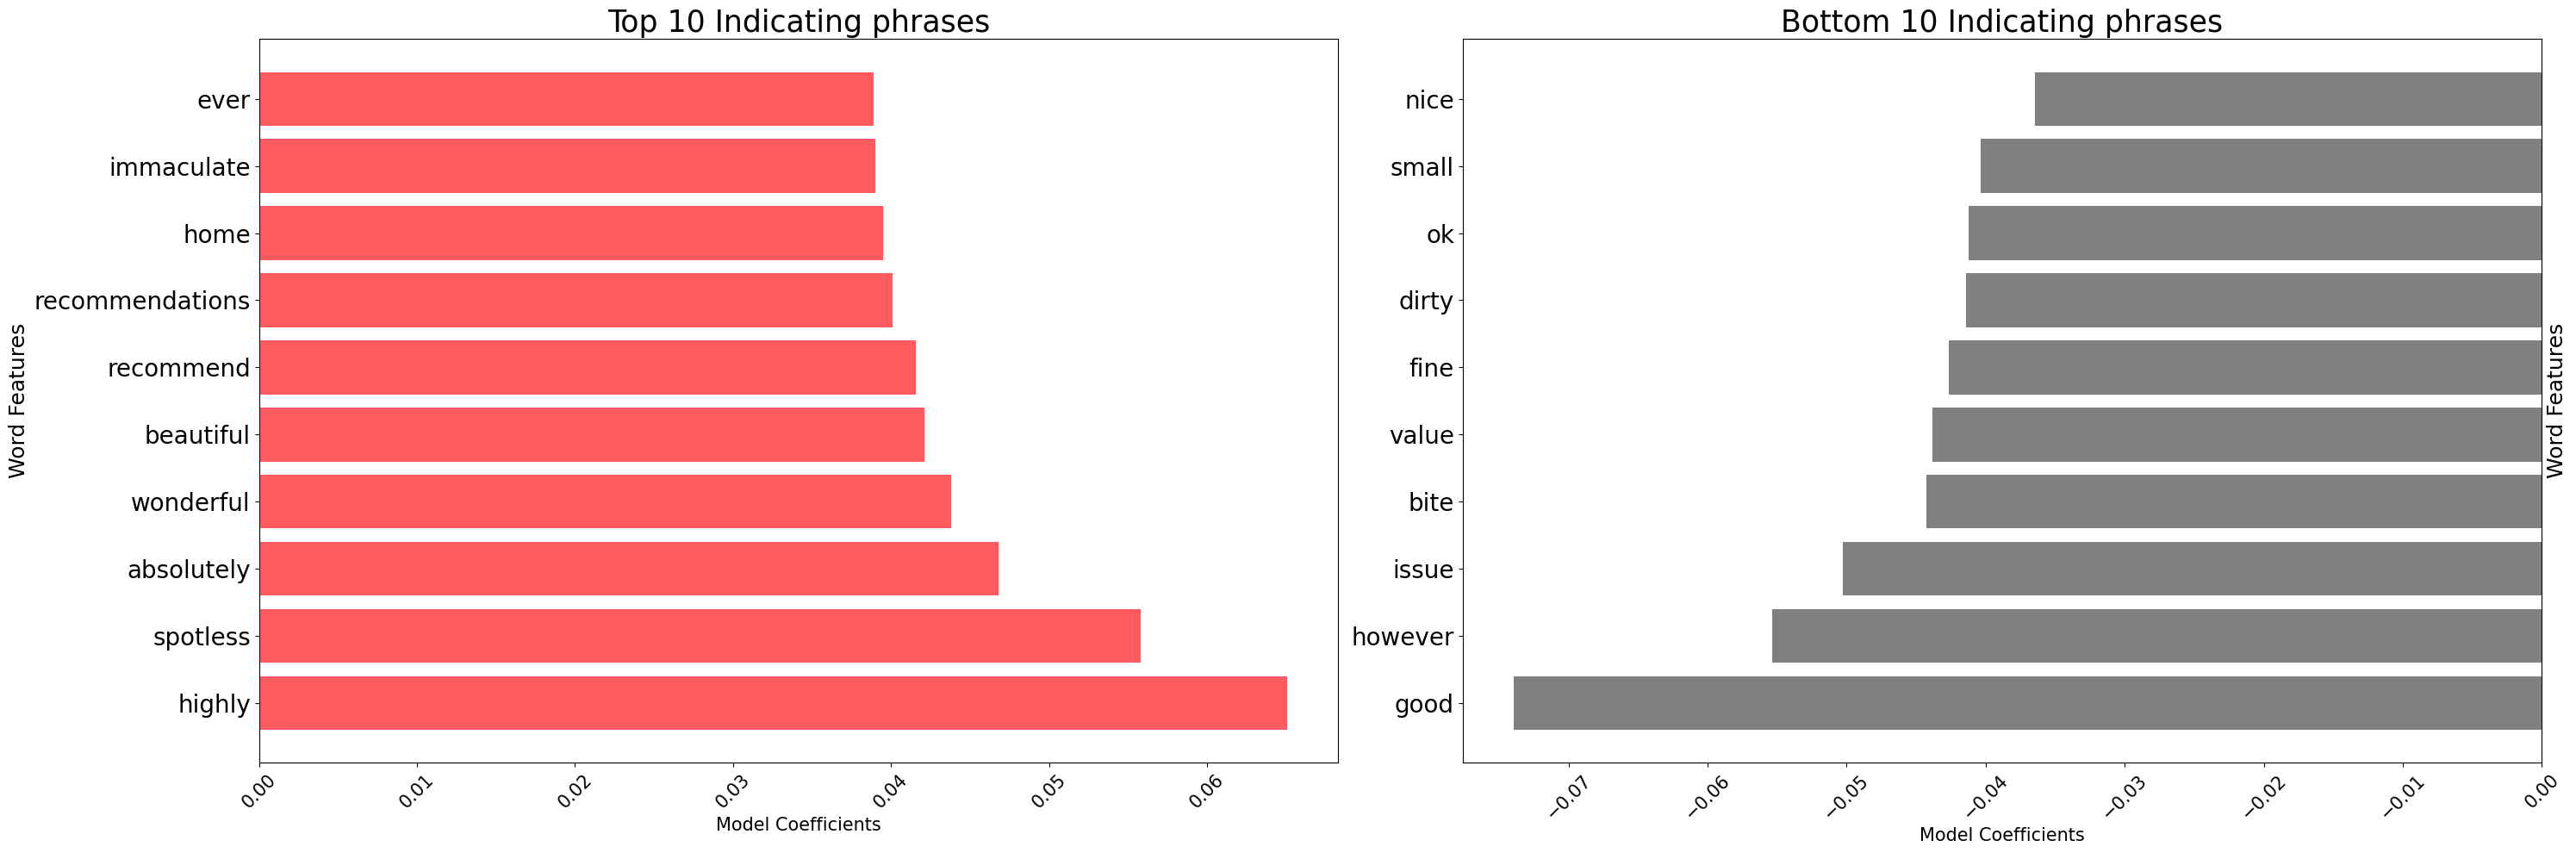

In [13]:
extract_key_words_plot_log(fittedgrid_1_bow_collapsed, ct_tfidf, 10, 'ct_tfidf')

### GridSearch_3 Summary

The results extracted from GridSearch_3 provide more information compared to the previous models. Since our selected model is the Logistic Regression model, we can observe from the left plot that key phrases indicating model predictions show extreme positivity, with '**absolutely**', '**spotless**', '**wonderful**', and '**immaculate**' being extracted, and '**highly**' adding more than a **0.6%** odds increase for the model to make the classification. On the right-hand side, we can see that '**good**' or '**ok**' guest reviews are not strong enough indicators to predict the listing as outstanding. Moreover, several negative phrases are extracted, such as '**dirty**', '**bite**', '**issue**', '**small**', etc. These negative words can provide insights for hosts to reflect on and potentially improve on their Airbnb rentals.

Our next GridSearch will include **n-grams**, where a similar approach to the one described above will be taken. We hope for better **generalization** and **interpretability**.

## GridSearch 4 Results and Summary

In [47]:
X_train_ct_tfidf_ngrams= ct_tfidf_ngrams.fit_transform(X_train)
X_test_ct_tfidf_ngrams = ct_tfidf_ngrams.transform(X_test)

#### GridSearch_4 Confusion Matrix

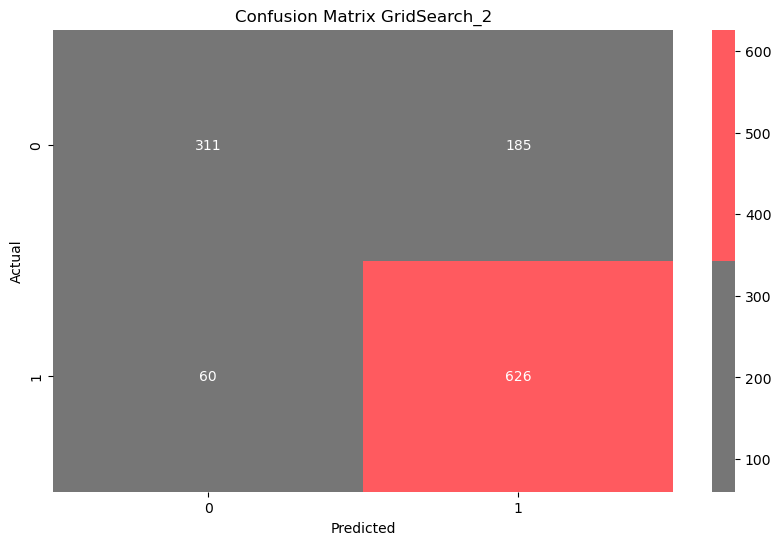

In [51]:
# Import pre-trained fitted grid
fittedgrid_2_tfidf_collapsed = joblib.load('data/fittedgrid_2_tfidf_collapsed.pkl')

# Test data predictions 
y_pred_grid4 = fittedgrid_2_tfidf_collapsed.best_estimator_.predict(X_test_ct_tfidf_ngrams)

# Compute Confusion Matrix
Confusion_Matrix_grid4 = confusion_matrix(y_test, y_pred_grid4)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid4, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_2')

plt.show()

#### GridSearch_4 Classification Report

In [52]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid4))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72       496
           1       0.77      0.91      0.84       686

    accuracy                           0.79      1182
   macro avg       0.81      0.77      0.78      1182
weighted avg       0.80      0.79      0.79      1182



#### GridSearch_4 Phrases Features

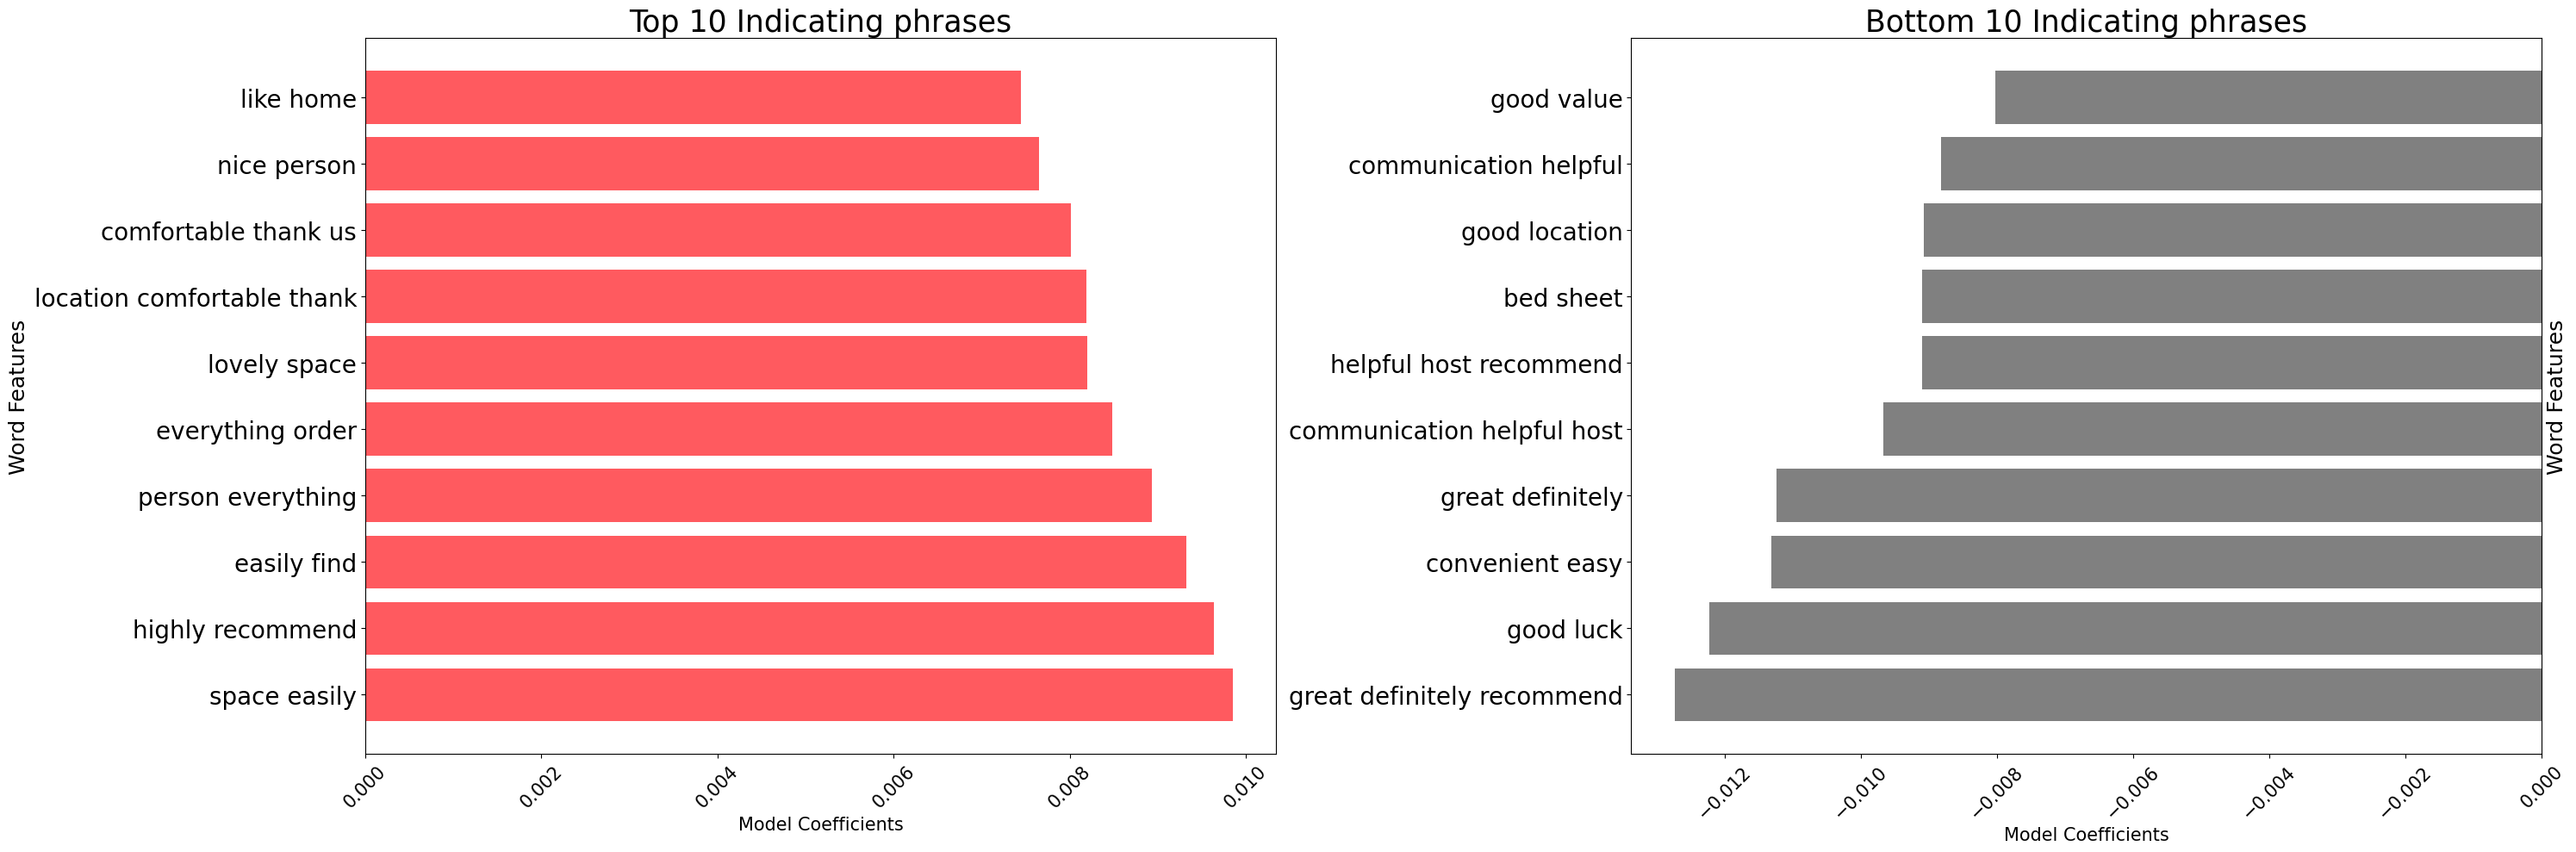

In [53]:
extract_key_words_plot_log(fittedgrid_2_tfidf_collapsed, ct_tfidf_ngrams, 10, 'ct_tfidf')

### GridSearch_4 Summary

In the last grid search, we aimed for better model generalization and interpretability. However, due to overfitting on the training dataset, we observed that the model's performance got worse, which is reflected in the extracted phrases. The top indicating phrases in this GridSearch still mostly relate to location, while the bottom 10 indicating phrases are a mix of positive phrases as well. This indicates that after including n-grams in our analysis, our model failed to capture listing-related specific features in the mixture of overall review data.

***

# Analysis on Subratings as Model Target Variables:

In [55]:
# Define X for general feature dataset
X = df_reviews_by_listing.drop(['listing_id',
                                'Overall_sentiment',
                               'accuracy_sentiment',
                               'cleanliness_sentiment',
                               'checkin_sentiment',
                               'communication_sentiment',
                               'location_sentiment',
                               'value_sentiment'], axis=1)

# Define different target variables
y_cleanliness = df_reviews_by_listing['cleanliness_sentiment']
y_checkin = df_reviews_by_listing['checkin_sentiment']
y_communication = df_reviews_by_listing['communication_sentiment']
y_location = df_reviews_by_listing['location_sentiment']

# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train_checkin, X_test_checkin, y_train_checkin, y_test_checkin = train_test_split(X, y_checkin, test_size=0.3, random_state=1)
X_train_cleanliness, X_test_cleanliness, y_train_cleanliness, y_test_cleanliness = train_test_split(X, y_cleanliness, test_size=0.3, random_state=12)
X_train_communication, X_test_communication, y_train_communication, y_test_communication = train_test_split(X, y_communication, test_size=0.3, random_state=123)
X_train_location, X_test_location, y_train_location, y_test_location = train_test_split(X, y_location, test_size=0.3, random_state=1234)

# Return downsampled training data for all subratings
X_train_sample_checkin, y_train_sample_checkin = downsample_train(X_train_checkin, y_train_checkin, 'checkin_sentiment', 0.03)
X_train_sample_cleanliness, y_train_sample_cleanliness = downsample_train(X_train_cleanliness, y_train_cleanliness, 'cleanliness_sentiment', 0.03)
X_train_sample_communication, y_train_sample_communication = downsample_train(X_train_communication, y_train_communication, 'communication_sentiment', 0.03)
X_train_sample_location, y_train_sample_location = downsample_train(X_train_location, y_train_location, 'location_sentiment', 0.03)

# Create train-test-split downsampled groups for each subrating for future loops
split_checkin= [X_train_sample_checkin, X_test_checkin, y_train_sample_checkin, y_test_checkin]
split_cleanliness = [X_train_sample_cleanliness, X_test_cleanliness, y_train_sample_cleanliness, y_test_cleanliness] 
split_communication = [X_train_sample_communication, X_test_communication, y_train_sample_communication, y_test_communication]
split_location = [X_train_sample_location, X_test_location, y_train_sample_location, y_test_location]

# Group all subrating train-test-split data together
all_splits= [split_checkin, split_cleanliness, split_communication, split_location]

# Load pre-trained TF-IDF transformed fittedgrids for all subratings
fittedgrid_tfidf_checkin = joblib.load('data/fittedgrid_tfidf_checkin.pkl')
fittedgrid_tfidf_cleanliness = joblib.load('data/fittedgrid_tfidf_cleanliness.pkl')
fittedgrid_tfidf_communication = joblib.load('data/fittedgrid_tfidf_communication.pkl')
fittedgrid_tfidf_location = joblib.load('data/fittedgrid_tfidf_location.pkl')

# Subrating names as function input
subrating_names = ['checkin','cleanliness', 'communication', 'location']

##  Results and Summary

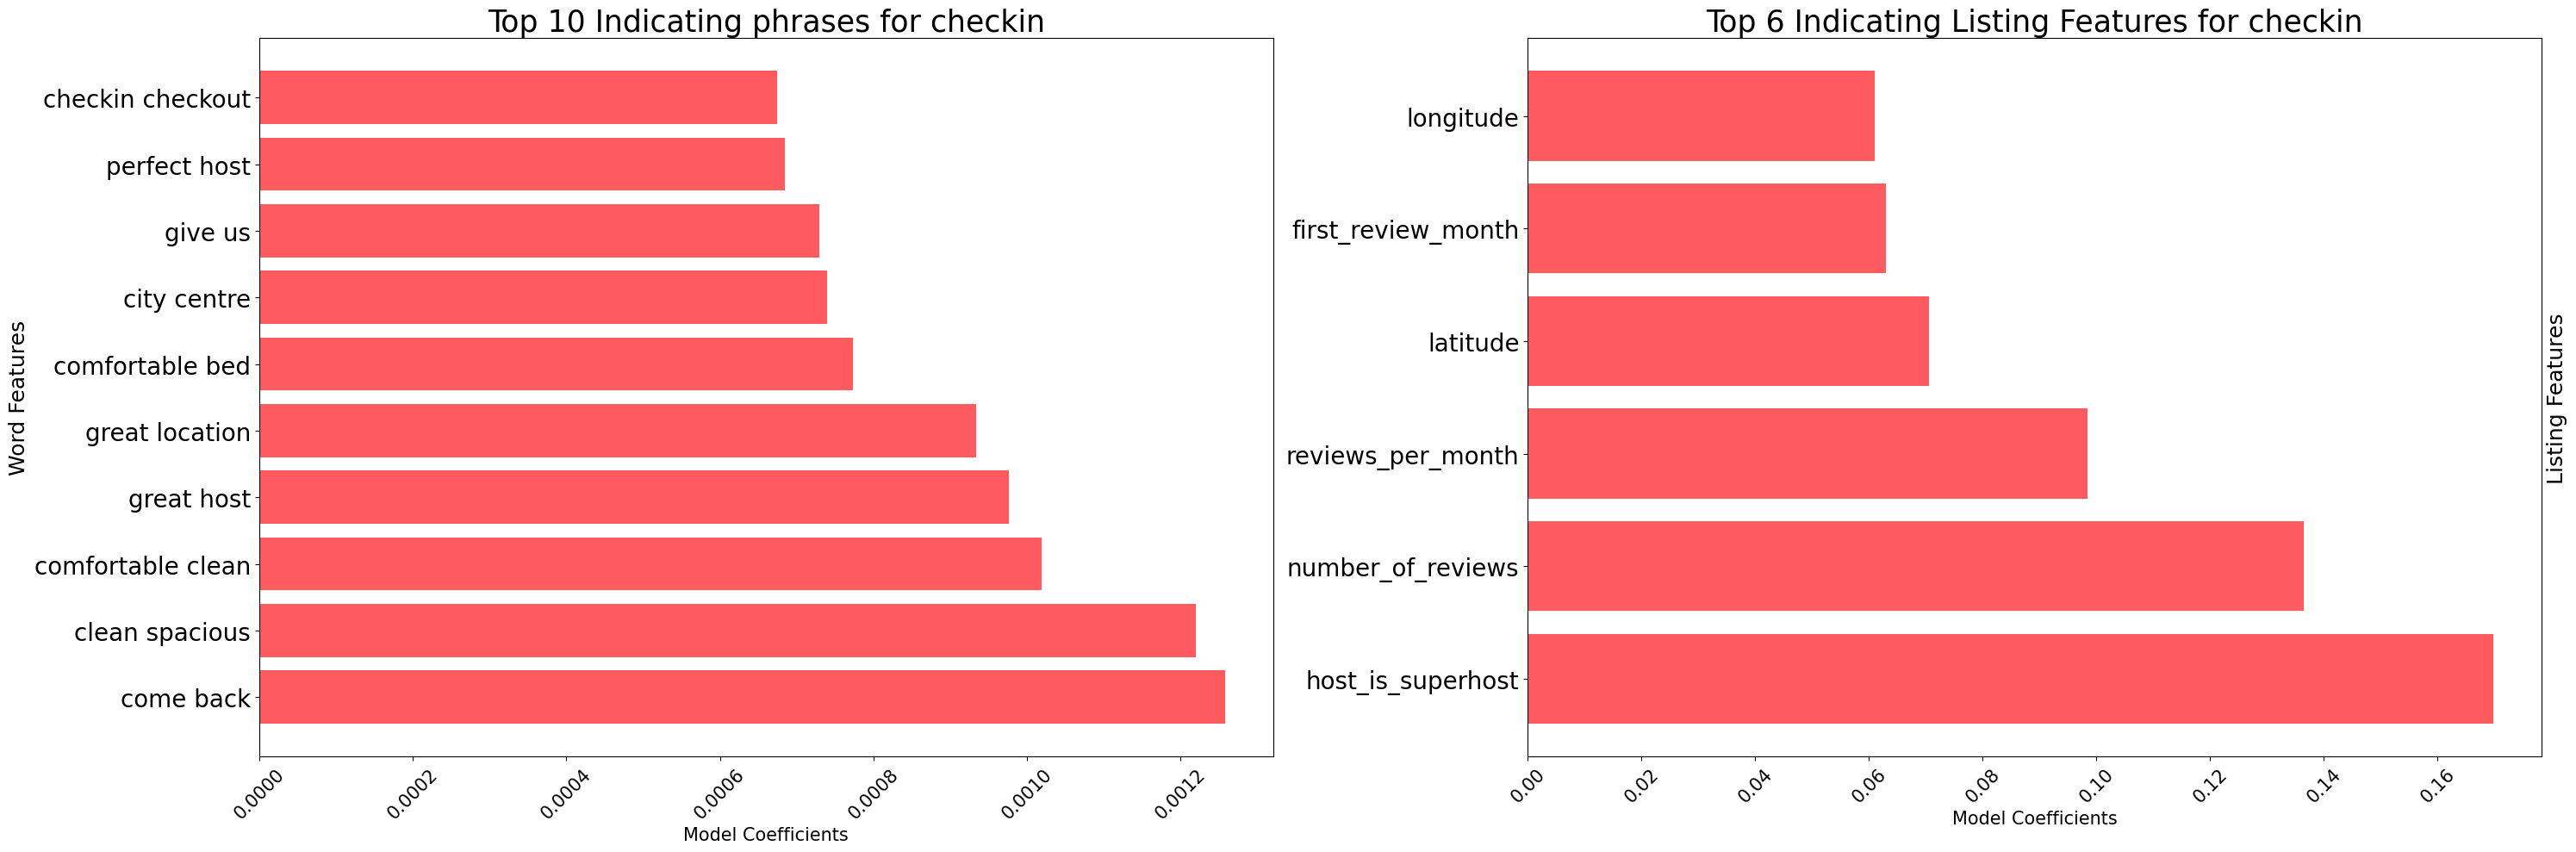

In [79]:
X_train_sample, X_test, y_train_sample, y_test = all_splits[0][0], all_splits[0][1], all_splits[0][2], all_splits[0][3]
ct_tfidf_ngrams.fit_transform(X_train_sample)
extract_key_words_plot_subrating(fittedgrid_tfidf_checkin, ct_tfidf_ngrams, 10, 'ct_tfidf', subrating_names[0])

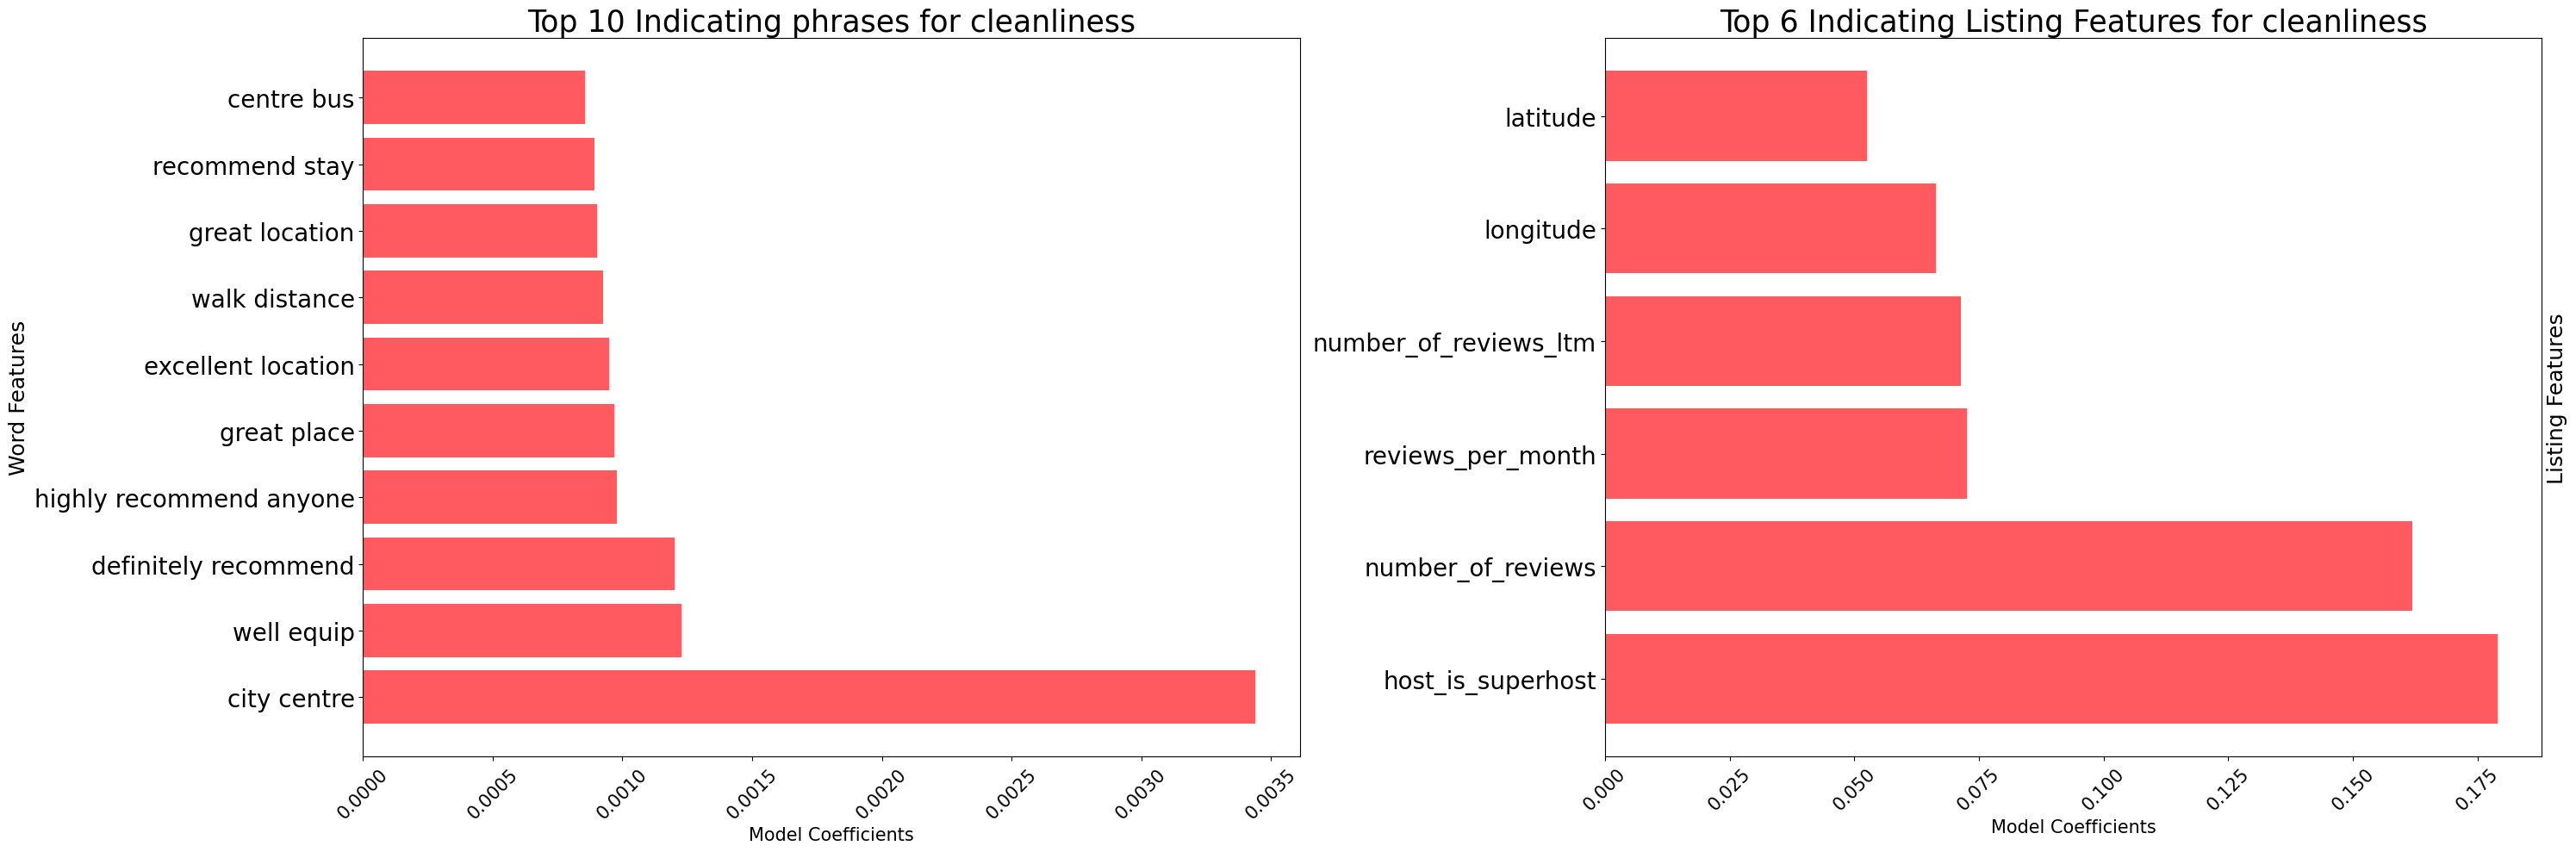

In [81]:
X_train_sample, X_test, y_train_sample, y_test = all_splits[1][0], all_splits[1][1], all_splits[1][2], all_splits[1][3]
ct_tfidf_ngrams.fit_transform(X_train_sample)
extract_key_words_plot_subrating(fittedgrid_tfidf_cleanliness, ct_tfidf_ngrams, 10, 'ct_tfidf', subrating_names[1])

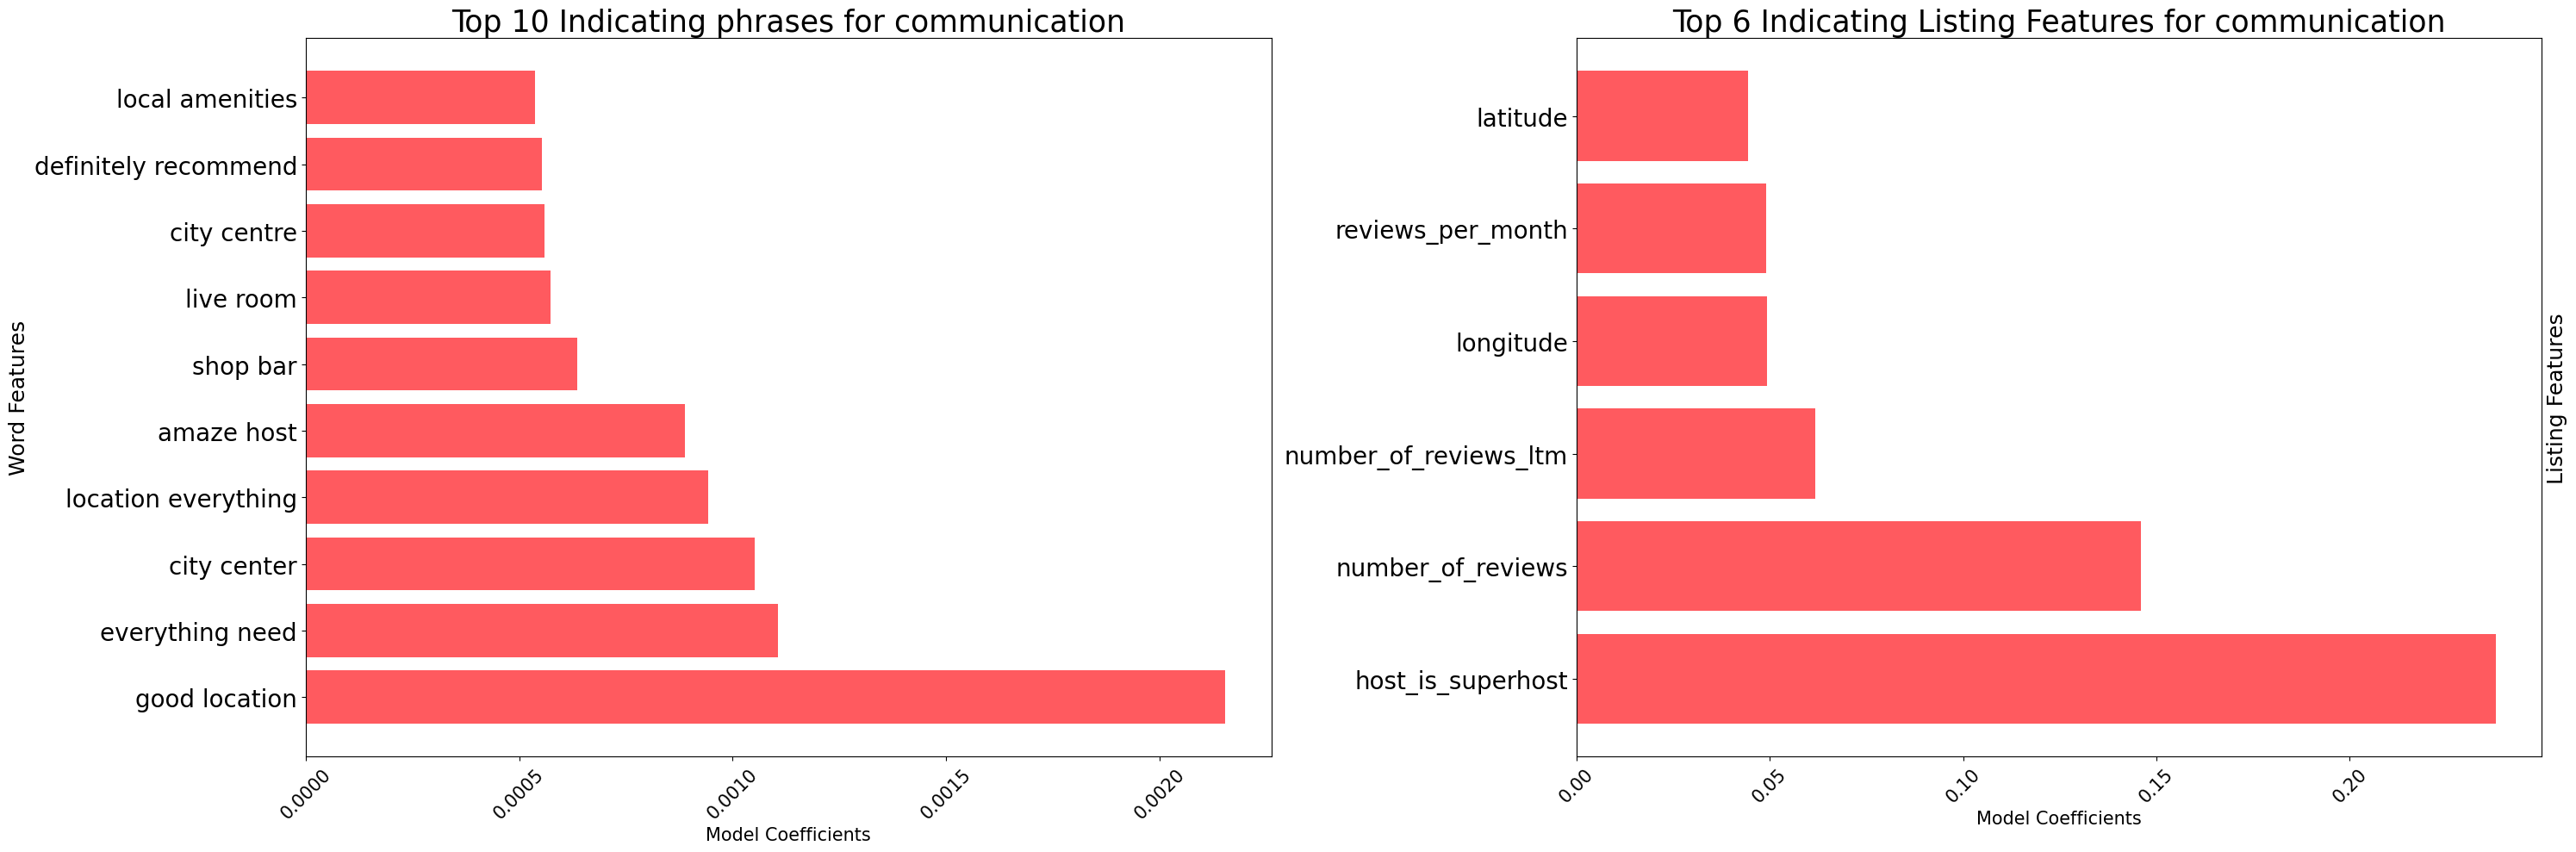

In [83]:
X_train_sample, X_test, y_train_sample, y_test = all_splits[2][0], all_splits[2][1], all_splits[2][2], all_splits[2][3]
ct_tfidf_ngrams.fit_transform(X_train_sample)
extract_key_words_plot_subrating(fittedgrid_tfidf_communication, ct_tfidf_ngrams, 10, 'ct_tfidf', subrating_names[2])

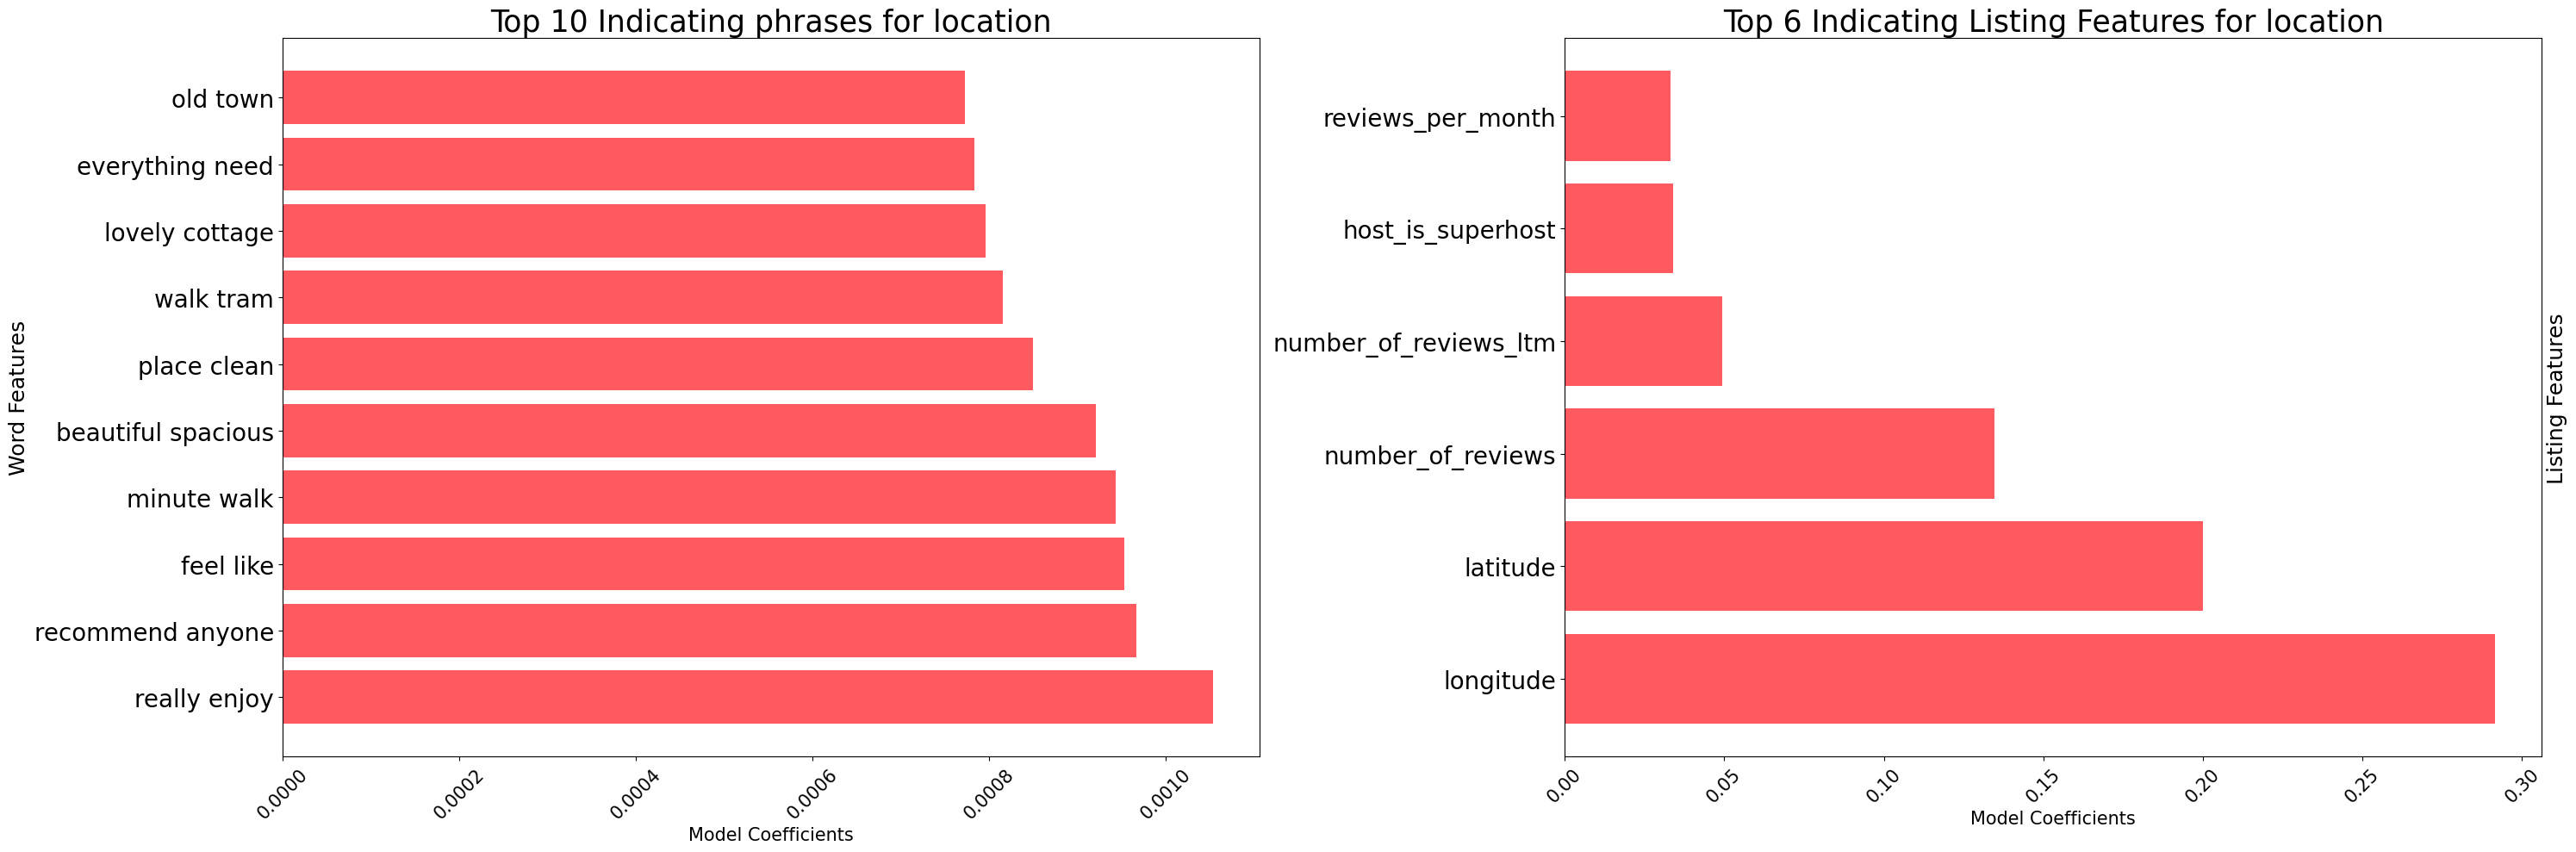

In [85]:
X_train_sample, X_test, y_train_sample, y_test = all_splits[3][0], all_splits[3][1], all_splits[3][2], all_splits[3][3]
ct_tfidf_ngrams.fit_transform(X_train_sample)
extract_key_words_plot_subrating(fittedgrid_tfidf_location, ct_tfidf_ngrams, 10, 'ct_tfidf', subrating_names[3])

### Subrating results summary

We conducted analysis on four different subrating scores as target variables, aiming to extract insights for features during the model training phase. However, we observed that the extracted phrases are nearly unrelated to the subrating categories. 

For example, when the target variable is `check-in`, the top phrases are '**comfortable clean**', '**clean spacious**', and '**come back**'; when the target variable is `cleanliness`, location-related features such as '**city center**' and '**walking distance**' can be seen in the top phrases; and when the target variable is `communication`, we also notice that location-related features are considered important, with '**good location**' and '**city center**' appearing again as top phrases. Finally, when the target variable is `location`, we observe phrases like '**minute walk**', '**walk tram**', and '**old town**', which are more specific location-related features.

The potential reasons for these mismatches are the **high correlation coefficients** among the subrating scores, as shown in the correlation heatmap in the EDA notebook. Upon examining these coefficients, we find that the location subrating had the lowest correlation coefficients with all other subratings, indicating that predictions for location subrating outcomes seem to have the best interpretational performance. On the right plot, we also observe that for data integration, our model captures the characteristics of the location subratings, where **longitude** and **latitude** appear to be the most important listing-related features.

# Actionable Insights

## Become a Superhost

Based on our comprehensive findings, we observe that whether a host is a superhost or not is a key indicator for the model to predict whether a listing is outstanding or not. Upon research, we found that one of the official requirements for Airbnb to decide if a host can become a superhost is if their overall rating score is more than 4.8. This adds more practical significance to our analysis since our project proposal can provide potential benefits Airbnb offers for superhosts.

Morover, becoming a superhost on Airbnb can receive numerous benefits such as increased visibility in search results, exclusive support services, and a prominent badge on listings. Superhosts may also command higher rates and attract more bookings due to their reputation for exceptional hospitality. Therefore, our analysis illuminates the factors impacting listing performance on Airbnb and emphasizes the significance of superhost status in the platform's ecosystem. By applying our findings, hosts can aim for superhost status, and guests can enjoy enhanced experiences when booking accommodations.

## Location is the Key
We observed that among most of the feature extraction plots, the location of the Airbnb is a key indicator, especially in the city of **Edinburgh**. Key words that hosts can keep in mind when deciding on the location of their potential listing include:

- city center
- Arthur's Seat
- walking distance to tramline
- old town

Note that these features are highly data-related. We expect that the key features extracted will differ among guest reviews if we change the city of the dataset in our analysis.

## Outstanding Listings have 'Immaculate' Reviews

Through analysis, we observe that maintaining a rating score of 4.8 is highly competitive in the Airbnb market. Hosts must uphold exceptional performances, as mediocre feedback from guests may result in ratings falling below the 'outstanding' threshold. However, for hosts wishing to enhance their listings, the subrating categories are crucial aspects to consider, as subrating-related keywords appear non-negligible in our analysis.

# Next Steps

- Attempt to obtain more accurate rating scores for individual reviews for analysis.
- Perform feature engineering on reviews with the aim of extracting individual listing-related features for models to make predictions.
- Include more in-depth models to better interpret modeling results and provide more insightful findings for Airbnb hosts.
- Conduct similar analyses on different city Airbnb datasets to observe how features differ among them.